<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.b.isolation-forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.utils import shuffle



# I prepared these libraries for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from andrea_models import subsample
from visualization import silhouette_diagram

--2020-04-02 18:37:43--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py.3’

andrea_models.py.3  100%[===================>]   3.12K  --.-KB/s    in 0s      

2020-04-02 18:37:43 (85.0 MB/s) - ‘andrea_models.py.3’ saved [3190/3190]

--2020-04-02 18:37:45--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP reque

The following code is the same as in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb).

In [0]:
np.random.seed(9)
random.seed(9)

! wget https://datahub.io/machine-learning/creditcard/r/creditcard.csv

df = pd.read_csv('creditcard.csv')
df.head()

df.info(verbose=True)
df['Class'].value_counts()
num_of_normal = sum( df['Class']=="'0'" )
num_of_anomalies = sum( df['Class']=="'1'" )
num_of_anomalies/num_of_normal

df = df.drop('Time', axis=1)
X = df.drop('Class', axis=1)
y = [1 if c=="'1'" else 0 for c in df['Class']] 

--2020-04-02 17:27:10--  https://datahub.io/machine-learning/creditcard/r/creditcard.csv
Resolving datahub.io (datahub.io)... 104.18.49.253, 104.18.48.253, 2606:4700:3031::6812:30fd, ...
Connecting to datahub.io (datahub.io)|104.18.49.253|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv [following]
--2020-04-02 17:27:14--  https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 104.18.49.253, 104.18.48.253, 2606:4700:3033::6812:31fd, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|104.18.49.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151114991 (144M) [text/csv]
Saving to: ‘creditcard.csv’

creditcard.csv      100%[===================>] 144.11M  29.5MB/s    in 6

Differently than KMeans, isolation forests do not need any scaling.

# Anomaly detection

We will apply isolation forests on the credit card fraud dataset, already used in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb). A similar notebook can be found in [Kaggle](https://www.kaggle.com/amarnayak/testing-isolation-forest-for-fraud-detection). 

 As in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb), we separate training and test set.

In [0]:
X, y = shuffle(X,y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
model = IsolationForest()

Our approach is unsupervised, so we **don't use y into fit(..)**

In [0]:
model.fit(X_train)
anomaly_scores = - model.decision_function(X_train)

Text(0.5, 0, 'Recall')

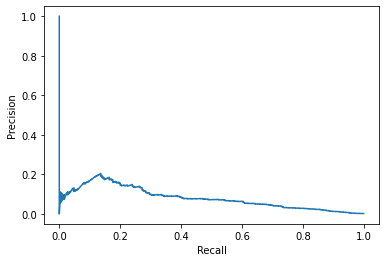

In [0]:
precision, recall, thresholds = precision_recall_curve(y_train, anomaly_scores)
plt.plot(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall')

Our isolation tree is still bad. We expect a very small Area Under the Curve (AUC).

In [0]:
auc_score = average_precision_score(y_train,anomaly_scores)
auc_score

0.07955914347014917

Create a function to put all these evaluations together

In [0]:
def evaluate_anomaly_detector(y_train, anomaly_scores):
  precision, recall, thresholds = precision_recall_curve(y_train, anomaly_scores)
  plt.plot(recall, precision)
  plt.ylabel('Precision')
  plt.xlabel('Recall')

  auc_score = average_precision_score(y_train,anomaly_scores)
  print("Area under the precision-recall curve:", auc_score)

  return precision, recall, thresholds, auc_score

# Hyper-paramter tuning


### Number of trees

Increasing the number of trees always improves performance

In [0]:
model = IsolationForest(n_estimators=500)
model.fit(X_train)


NameError: ignored

Area under the precision-recall curve: 0.18540235602150487


(array([0.00196929, 0.00196143, 0.00196145, ..., 0.        , 0.        ,
        1.        ]),
 array([1.   , 0.996, 0.996, ..., 0.   , 0.   , 0.   ]),
 array([-0.13753976, -0.13753806, -0.13753805, ...,  0.24047163,
         0.25434504,  0.25590498]),
 0.18540235602150487)

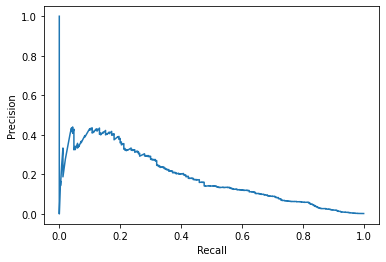

In [0]:
anomaly_scores = -model.decision_function(X_train)
evaluate_anomaly_detector(y_train, anomaly_scores)

### Others

GridSearch from `sklearn` is not simple (however not impossible) to apply. It is more simple to make a grid search manually

In [0]:
iforest = IsolationForest(n_estimators=500)

for max_features in range(1,22, 7):
  for max_samples in range(256, X_train.shape[0], int(X_train.shape[0] / 3) ):
    model = IsolationForest(n_estimators=500, max_features=max_features,
                            max_samples = max_samples)
    model.fit(X_train)
    anomaly_scores = -model.decision_function(X_train)
    auc_score = average_precision_score(y_train, anomaly_scores)
    print("max_fetaures:", max_features, "; max_samples:", max_samples, 
          "auc_score:", auc_score)

max_fetaures: 1 ; max_samples: 256 auc_score: 0.18255187359521147
max_fetaures: 1 ; max_samples: 47723 auc_score: 0.19806738394419995
max_fetaures: 1 ; max_samples: 95190 auc_score: 0.19658597316539578
max_fetaures: 8 ; max_samples: 256 auc_score: 0.16442943684946978
max_fetaures: 8 ; max_samples: 47723 auc_score: 0.2447546777362474
max_fetaures: 8 ; max_samples: 95190 auc_score: 0.23576343074761147
max_fetaures: 15 ; max_samples: 256 auc_score: 0.1704741582775213
max_fetaures: 15 ; max_samples: 47723 auc_score: 0.24730832510099937
max_fetaures: 15 ; max_samples: 95190 auc_score: 0.24086041045913079


Let's evaluate the best configuration we found

Area under the precision-recall curve: 0.23296094778395748


(array([0.00205487, 0.00204667, 0.00204669, ..., 0.        , 0.        ,
        1.        ]),
 array([1.   , 0.996, 0.996, ..., 0.   , 0.   , 0.   ]),
 array([-0.17609601, -0.17609587, -0.1760958 , ...,  0.28075405,
         0.29920244,  0.32541908]),
 0.23296094778395748)

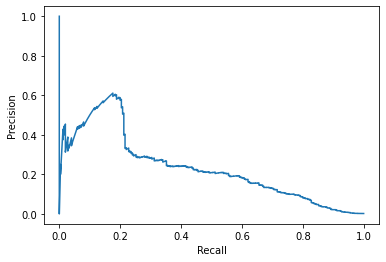

In [0]:
n_estimators=500
max_features = 15
max_samples = 47723

model = IsolationForest(n_estimators=n_estimators, max_features=max_features,
                        max_samples=max_samples)

model.fit(X_train)
anomaly_scores = -model.decision_function(X_train)
evaluate_anomaly_detector(y_train, anomaly_scores)

Note that `auc_score` is different, since isolation forests have a lot of randomness.

It seems that increasing the number of `max_features` improves the forest. Let us try with all the features

Area under the precision-recall curve: 0.24602274776579133


(array([0.0022112 , 0.00220237, 0.00220239, ..., 0.        , 0.        ,
        1.        ]),
 array([1.   , 0.996, 0.996, ..., 0.   , 0.   , 0.   ]),
 array([-0.17634882, -0.17634834, -0.17634833, ...,  0.28178777,
         0.29486868,  0.31571696]),
 0.24602274776579133)

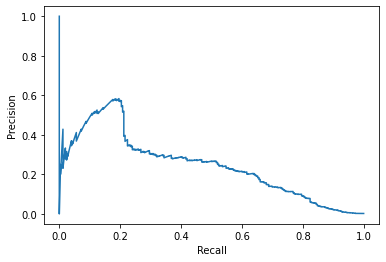

In [0]:
max_features = X_train.shape[1]

model = IsolationForest(n_estimators=n_estimators, max_features=max_features,
                        max_samples=max_samples)

model.fit(X_train)
anomaly_scores = -model.decision_function(X_train)
evaluate_anomaly_detector(y_train, anomaly_scores)

No real improvement. Try to increase the number of trees.

Area under the precision-recall curve: 0.2407254754536009


(array([0.00215536, 0.00214676, 0.00214677, ..., 0.        , 0.        ,
        1.        ]),
 array([1.   , 0.996, 0.996, ..., 0.   , 0.   , 0.   ]),
 array([-0.17773198, -0.17773187, -0.17773167, ...,  0.28397147,
         0.29888819,  0.31850182]),
 0.2407254754536009)

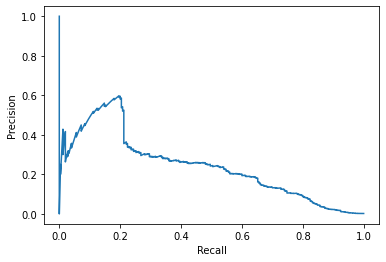

In [0]:
n_estimators = 2500

model = IsolationForest(n_estimators=n_estimators, max_features=max_features,
                        max_samples=max_samples)

model.fit(X_train)
anomaly_scores = -model.decision_function(X_train)
evaluate_anomaly_detector(y_train, anomaly_scores)

# ROC curve

Add to our evaluation function the code to plot the ROC curve

In [0]:
def evaluate_anomaly_detector(y_train, anomaly_scores):
  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 8))

  precision, recall, thresholds = precision_recall_curve(y_train, anomaly_scores)
  ax1.plot(recall, precision)
  ax1.set_ylabel('Precision')
  ax1.set_xlabel('Recall')

  ### New part
  fpr, tpr, thresholds_roc = roc_curve(y_train, anomaly_scores)
  ax2.plot(fpr, tpr)
  ax2.set_ylabel('True Positive Rate')
  ax2.set_xlabel('False Positive Rate')

  pr_auc_score = average_precision_score(y_train,anomaly_scores)
  roc_auc_sc = roc_auc_score(y_train, anomaly_scores)

  print("Area under the precision-recall curve:", pr_auc_score)
  print("Area under the ROC curve:", roc_auc_sc)

  return precision, recall, thresholds

Area under the precision-recall curve: 0.2407254754536009
Area under the ROC curve: 0.95984788221142


(array([0.00215536, 0.00214676, 0.00214677, ..., 0.        , 0.        ,
        1.        ]),
 array([1.   , 0.996, 0.996, ..., 0.   , 0.   , 0.   ]),
 array([-0.17773198, -0.17773187, -0.17773167, ...,  0.28397147,
         0.29888819,  0.31850182]))

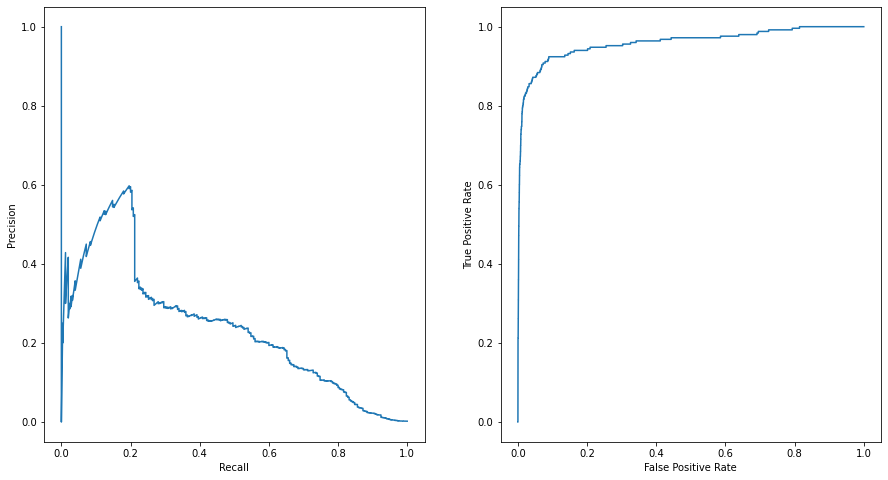

In [0]:
evaluate_anomaly_detector(y_train, anomaly_scores)

Observe that:
* Precision and recall is "merciless". This is because it is very difficult to be "precise"
* If we wanto to find 80% of anomalies, every alarm is true only 10% of the times

# Todo

Check:
* https://medium.com/datadriveninvestor/credit-card-fraud-detection-using-local-outlier-factor-and-isolation-forest-in-python-56edd0a44af5
* https://medium.com/learningdatascience/anomaly-detection-techniques-in-python-50f650c75aaf